In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Normalization, BatchNormalization, Dropout, LeakyReLU, ELU, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB3, efficientnet_v2
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adagrad, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC

dataset_folder = "/content/drive/MyDrive/Agricultural-crops"

image_paths = []
labels = []
classes = os.listdir(dataset_folder)
n_classes = len(classes)
for c in classes:
    class_folder = dataset_folder + "/" + c
    for image in os.listdir(class_folder):
        image_path = class_folder + "/" + image
        image_paths.append(image_path)
        labels.append(c)

df = pd.DataFrame({"image_path": image_paths, "label": labels})

train_df, val_df = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=666)

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2),
    shear_range=0.1,
    channel_shift_range=0.1
)

ts = 224 ; # 384


train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col="image_path",
    y_col="label",
    target_size=(ts, ts),
    class_mode="categorical",
    shuffle=False
)

val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col="image_path",
    y_col="label",
    target_size=(ts, ts),
    class_mode="categorical",
    shuffle=False
)
tf.test.is_gpu_available()

Found 580 validated image filenames belonging to 30 classes.
Found 249 validated image filenames belonging to 30 classes.


False

In [ ]:
val_df

,image_path,label
354,/content/drive/MyDrive/Agricultural-crops/jute...,jute
143,/content/drive/MyDrive/Agricultural-crops/clov...,clove
107,/content/drive/MyDrive/Agricultural-crops/Cucu...,Cucumber
539,/content/drive/MyDrive/Agricultural-crops/papa...,papaya
825,/content/drive/MyDrive/Agricultural-crops/rice...,rice
...,...,...
757,/content/drive/MyDrive/Agricultural-crops/whea...,wheat
12,/content/drive/MyDrive/Agricultural-crops/bana...,banana
25,/content/drive/MyDrive/Agricultural-crops/bana...,banana
676,/content/drive/MyDrive/Agricultural-crops/soya...,soyabean


In [ ]:
import matplotlib.pyplot as plt
import time





base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(ts, ts, 3),
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    classes=n_classes,
    pooling=None,
    dropout_rate=0.5,
    include_preprocessing=True,
)


base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(n_classes, activation="softmax")
])

optimizer = optimizers.RMSprop(learning_rate=0.0008 )


model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1.0e-15)
checkpoint = ModelCheckpoint('model{"val_loss":.2f}.h5', monitor=model.compiled_metrics, verbose=0, save_best_only=True, mode='max')
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.005, decay_rate=0.5, decay_steps=1, staircase=True)
cos_decay = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
inicio = time.time()

history = model.fit(
    train_generator,
    epochs=20,
    batch_size=4,
    validation_data=val_generator,
    callbacks=[early_stopping]
)
# Grava o tempo final
fim = time.time()

tempo_total = fim - inicio
print(f"Tempo de execução: {tempo_total} segundos")





Epoch 1/20
19/19 [==============================] - 52s 2s/step - loss: 4.0717 - accuracy: 0.0397 - val_loss: 3.2628 - val_accuracy: 0.1205
Epoch 2/20
19/19 [==============================] - 30s 2s/step - loss: 3.6001 - accuracy: 0.0741 - val_loss: 2.9960 - val_accuracy: 0.1365
Epoch 3/20
19/19 [==============================] - 32s 2s/step - loss: 3.3349 - accuracy: 0.0897 - val_loss: 2.7958 - val_accuracy: 0.2209
Epoch 4/20
19/19 [==============================] - 27s 1s/step - loss: 3.0355 - accuracy: 0.1517 - val_loss: 2.5802 - val_accuracy: 0.2771
Epoch 5/20
19/19 [==============================] - 31s 2s/step - loss: 2.8891 - accuracy: 0.1879 - val_loss: 2.4436 - val_accuracy: 0.3534
Epoch 6/20
19/19 [==============================] - 31s 2s/step - loss: 2.7199 - accuracy: 0.2052 - val_loss: 2.3576 - val_accuracy: 0.3855
Epoch 7/20
19/19 [==============================] - 30s 2s/step - loss: 2.5762 - accuracy: 0.2724 - val_loss: 2.2008 - val_accuracy: 0.4337
Epoch 8/20
19/19 [==

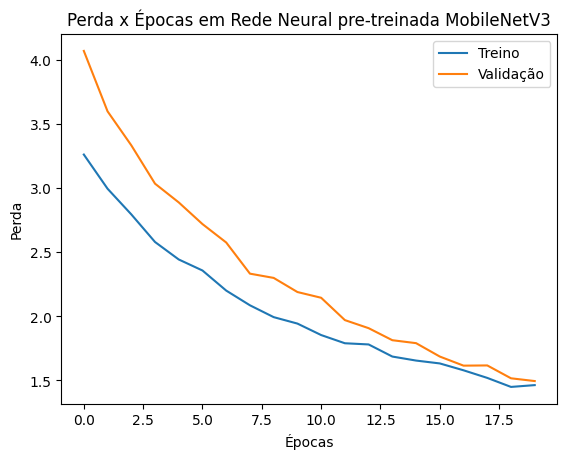

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Perda x Épocas em Rede Neural pre-treinada MobileNetV3')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.savefig('plot_salvato.png')
plt.show()

Key: loss, Value: [4.07170295715332, 3.600076913833618, 3.3349452018737793, 3.0355265140533447, 2.889115333557129, 2.7199270725250244, 2.576198101043701, 2.3329529762268066, 2.2997941970825195, 2.1895904541015625, 2.144788980484009, 1.970450758934021, 1.9074987173080444, 1.8134582042694092, 1.7904599905014038, 1.6858985424041748, 1.6149053573608398, 1.6165763139724731, 1.5161449909210205, 1.4945863485336304]
Key: accuracy, Value: [0.0396551713347435, 0.07413793355226517, 0.08965517580509186, 0.15172414481639862, 0.18793103098869324, 0.20517241954803467, 0.27241379022598267, 0.3206896483898163, 0.32758620381355286, 0.3534482717514038, 0.38620689511299133, 0.43448275327682495, 0.4568965435028076, 0.4965517222881317, 0.47413793206214905, 0.5293103456497192, 0.5431034564971924, 0.5465517044067383, 0.5724138021469116, 0.5724138021469116]
Key: val_loss, Value: [3.2627761363983154, 2.9960408210754395, 2.7957820892333984, 2.580160140991211, 2.443610668182373, 2.3576362133026123, 2.200795650482

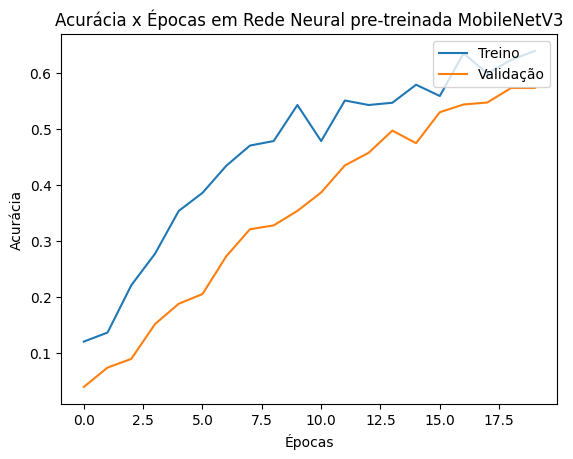

In [ ]:
for key, value in (history.history.items()):
    print(f'Key: {key}, Value: {value}')
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Acurácia x Épocas em Rede Neural pre-treinada MobileNetV3')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.show()